In [1]:
import numpy as np
import pandas as pd

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [3]:
from create_matrix import *
import os
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
import sys


appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [6]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [7]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [ ]:
pred = {}
for method in ['normal', 'transfer']:
    pred[method] = {}
    for train_iter in [200, 500, 1000, 1500, 2000]:
        pred[method][train_iter] = {}
        for algo in ['adagrad', 'gd']:
            pred[method][train_iter][algo] = {}
            for static_fac in ['static', 'None']:
                pred[method][train_iter][algo][static_fac] = {}
                for lam in [0.01, 0.1, 0, 1]:
                    lam = float(lam)
                    pred[method][train_iter][algo][static_fac][lam] = {}
                    for random_seed in range(10):
                        pred[method][train_iter][algo][static_fac][lam][random_seed] = load_obj("pred_explore/pred_" + method
                                                                                               + "_" + str(train_iter)
                                                                                               + "_" + algo
                                                                                               + "_" + static_fac
                                                                                               + "_" + str(lam)
                                                                                                +"_" + str(random_seed))

In [10]:
out_transfer = load_obj("out_explore/out_transfer_500_adagrad_static_0.01")
out_normal = load_obj("out_explore/out_normal_500_adagrad_static_0.01")

In [8]:
from common import compute_rmse_fraction
out = {}
for method in ['normal', 'transfer']:
    out[method] = {}
    for train_iter in [200, 500, 1000, 1500, 2000, 5000]:
        out[method][train_iter] = {}
        for algo in ['adagrad', 'gd']:
            out[method][train_iter][algo] = {}
            for static_fac in ['static', 'None']:
                out[method][train_iter][algo][static_fac] = {}
                for lam in [0.01, 0.1, 0, 1]:
                    lam = float(lam)
                    out[method][train_iter][algo][static_fac][lam] = {}
                    for random_seed in range(10):
                        out[method][train_iter][algo][static_fac][lam][random_seed] = {}
                        

In [15]:
from common import compute_rmse_fraction
out = {}
for method in ['normal', 'transfer']:
    out[method] = {}
    for train_iter in [5000]:
        out[method][train_iter] = {}
        for algo in ['gd']:
            out[method][train_iter][algo] = {}
            for static_fac in ['static']:
                out[method][train_iter][algo][static_fac] = {}
                for lam in [0]:
                    lam = float(lam)
                    out[method][train_iter][algo][static_fac][lam] = load_obj("out_explore/out_" + method
                                                                                 + "_" + str(train_iter)
                                                                                 + "_" + algo 
                                                                                 + "_" + static_fac
                                                                                 + "_" + str(lam))
                  

In [16]:
mean_out = {}

mean_out = {}
for method in ['normal', 'transfer']:
    mean_out[method] = {}
    for train_iter in [5000]:
        mean_out[method][train_iter] = {}
        for algo in ['gd']:
            mean_out[method][train_iter][algo] = {}
            for static_fac in ['static']:
                mean_out[method][train_iter][algo][static_fac] = {}
                for lam in [0]:
                    lam = float(lam)
                    mean_out[method][train_iter][algo][static_fac][lam] = pd.Panel(out[method][train_iter][algo][static_fac][lam]).mean(axis=0)


In [17]:
df_out = {}
for method in ['normal', 'transfer']:
    df_out[method] = {}
    for train_iter in [5000]:
        df_out[method][train_iter] = {}
        for algo in ['gd']:
            df_out[method][train_iter][algo] = {}
            for static_fac in ['static']:
                df_out[method][train_iter][algo][static_fac] = {}
                for lam in [0]:
                    lam = float(lam)
                    df_out[method][train_iter][algo][static_fac][lam] = pd.DataFrame(mean_out[method][train_iter][algo][static_fac][lam])
                    df_out[method][train_iter][algo][static_fac][lam] = df_out[method][train_iter][algo][static_fac][lam].rename(columns=
                                                {'dw': "dw_" + method + "_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam),
                                                  'wm': "wm_" + method + "_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam),
                                                  'mw': "mw_" + method + "_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam),
                                                  'oven': "oven_" + method + "_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam),
                                                  'fridge': "fridge_"+ method + "_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam),
                                                  'hvac': "hvac_" + method + "_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam)})

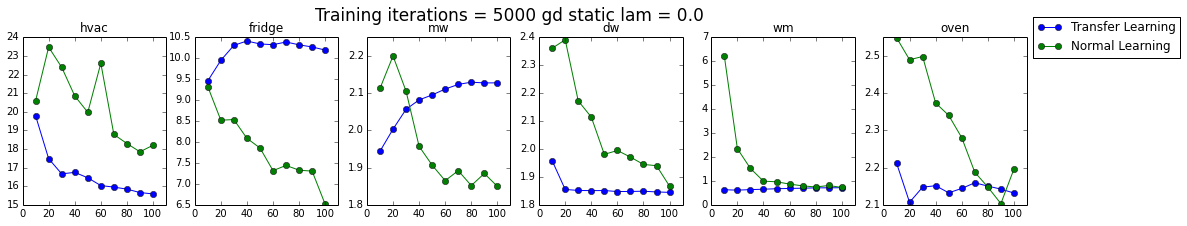

In [18]:


static_fac = 'static'
algo = 'adagrad'
lam = 0.01
train_iter = 500

for train_iter in [5000]:
    for algo in ['gd']:
        for static_fac in ['static']:
            for lam in [0]:
                lam = float(lam)
                fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 18))
                ax = axes.flatten()
                count = 0
                for appliance in APPLIANCES_ORDER[1:]:

                    df1 = df_out['transfer'][train_iter][algo][static_fac][float(lam)][appliance + "_transfer_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam)]
                    df2 = df_out['normal'][train_iter][algo][static_fac][float(lam)][appliance + "_normal_" + str(train_iter) + "_" + algo + "_" + static_fac+"_"+str(lam)]
                    df = pd.concat([df1, df2], axis = 1)

                    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
                    ax[count].legend().set_visible(False)
                    ax[count].set_title(appliance)
                    count += 1
                plt.suptitle("Training iterations = " + str(train_iter) + " " + algo + " " + static_fac + " " + "lam = " + str(lam), fontsize=17,y=1.04)
                ax[count-1].legend(['Transfer Learning', 'Normal Learning'], loc='center left' , bbox_to_anchor=(1, 1))
                plt.savefig("./analysis/0720/comparison_" + str(train_iter) + " " + algo + " " + static_fac + " " + str(lam) + ".pdf", bbox_inches="tight", dpi=300, format="pdf")